# MNIST - MLP and CNN with TF & Keras

## Lucas Pierezan

**Mar 2019**

The objectives:

- Build and train models: MLP and CNN.
- Experiment with Keras APIs (Sequential and Functional).
- Experiment with ImageDataGenerator to do data augmentation.
- Experiment with tf.data to build input pipeline (with data augmentation)

References:

For building the CNN:  

- https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b

For building a pipeline with tf.data:  

- https://www.tensorflow.org/guide/datasets
- https://gist.github.com/datlife/abfe263803691a8864b7a2d4f87c4ab8
- https://dominikschmidt.xyz/tensorflow-data-pipeline/
- https://cs230-stanford.github.io/tensorflow-input-data.html

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))


print(tf.__version__)
print(tf.keras.__version__)

tf.keras.backend.set_image_data_format('channels_first')

['train.csv', 'sample_submission.csv', 'test.csv']
1.12.0
2.1.6-tf


In [2]:
def plot_train_hist(hist : keras.callbacks.History, before_min_percent = 0.7):
    """
    Plot loss/acc curves over training data.
    """
    min_val_loss_epoch = hist.epoch[np.argmin(hist.history['val_loss'])]    
    st_epoch = int((1-before_min_percent)*min_val_loss_epoch)
    x_epoch = hist.epoch[st_epoch:]
    
    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(x_epoch, hist.history['val_loss'][st_epoch:], label = 'val_loss')
    ax.plot(x_epoch, hist.history['loss'][st_epoch:], label = 'train_loss')
    ax.set_ylabel('loss')

    ax2 = ax.twinx()
    ax2.plot(x_epoch, hist.history['val_acc'][st_epoch:], label = 'val_acc', c = 'r')
    ax2.plot(x_epoch, hist.history['acc'][st_epoch:], label = 'train_acc', c = 'g')
    ax2.set_ylabel('acc')
    
    
    ax.vlines(min_val_loss_epoch, *ax.get_ylim(), linestyles='dashed', label = 'min_val_loss')
    
    ax.legend(loc = 'upper left')
    ax2.legend(loc = 'upper right')
    
    #plt.legend()
    plt.show()

# Loading the Data

In [3]:
def load_data(train = True):
    fp = '../input/train.csv' if train else '../input/test.csv'
    df = pd.read_csv(fp)
    
    if train:
        y_train = df['label'].values
        df.drop('label',axis=1, inplace = True)
        
    x_train = df.values
    n,l2 = x_train.shape
    l = int(l2**0.5)
    x_train = x_train.reshape((n, l, l)).astype(float)
    
    if train:
        return x_train, y_train
    else:
        return x_train


x, y = load_data()
x_test = load_data(train=False)

x.shape, y.shape, x_test.shape

((42000, 28, 28), (42000,), (28000, 28, 28))

label 0
min: 0.0 max: 255.0


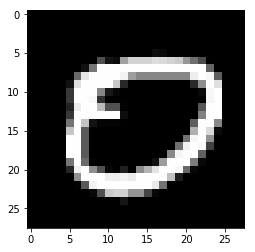

In [4]:
np.random.seed(42)

i = np.random.randint(0,len(x))
plt.imshow(x[i], cmap='gray', interpolation='none')
print('label', y[i])
print('min:', x.min(), 'max:',  x.max())

### Creating Validation Set

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((33600, 28, 28), (33600,), (8400, 28, 28), (8400,))

In [6]:
# are all classes represented?
pd.Series(y_val).value_counts()

3    937
1    909
7    893
2    846
4    839
9    838
8    835
0    816
6    785
5    702
dtype: int64

### Add Channels dimension

In [7]:
# Expanding x_train, x_test to have a channels dimension (and to be channels first)

x_train_k = np.expand_dims(x_train, axis = 1)
x_val_k = np.expand_dims(x_val, axis = 1)

x_train_k.shape, x_val_k.shape

((33600, 1, 28, 28), (8400, 1, 28, 28))

In [8]:
num_classes = 10
y_train_k = keras.utils.to_categorical(y_train, num_classes)
y_val_k = keras.utils.to_categorical(y_val, num_classes)
y_train_k.shape, y_val_k.shape

((33600, 10), (8400, 10))

# Keras ImageDataGenerator

Let´s use ImageDataGenerator to create a input pipelines with:

- Spliting data to validation
- Rescaling pixel by a constant value.
- Control batch size

These generators loop over their data indefinitely.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen_train = ImageDataGenerator(rescale=1/255., rotation_range = 12, width_shift_range=0.08, height_shift_range=0.08, zoom_range=0.08)
img_gen_val = ImageDataGenerator(rescale=1/255.)


img_gen_train.fit(x_train_k, seed=42)
img_gen_val.fit(x_train_k, seed=42)


**Testing the image data augmentation**

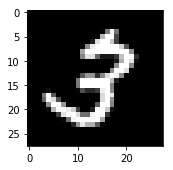

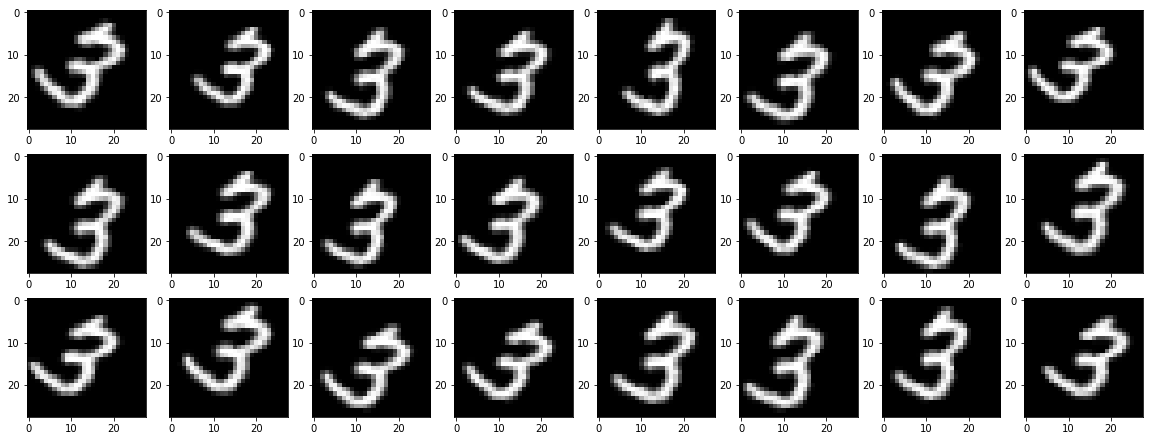

In [10]:
idx_example = np.random.randint(0,len(x_train_k))
fig, ax = plt.subplots(figsize = (2.5,2.5))
plt.imshow(x_train_k[idx_example][0], cmap='gray', interpolation='none')
plt.show()

n_row, n_col = 3, 8
fig, axs = plt.subplots(n_row, n_col, figsize = (2.5*n_col,2.5*n_row))
i = 0
for z in img_gen_train.flow(x_train_k[[idx_example]], batch_size=1):
    i += 1
    if i > n_row*n_col:
        break
    row, col = (i-1)//n_col, (i-1)%n_col    
    axs[row,col].imshow(z[0,0], cmap='gray', interpolation='none')
    
plt.show()

# MLP Model

Let´s fix an architeture that is composed by dense hidden layers with dropout beetween then and before the output layer.

Input -> Dense -> Dropout -> Dense -> Dropout -> Dense -> ... -> Dropout -> Output

In [11]:
def create_mlp_model(dense_sizes = [100,100], dropouts = [0.5, 0.5]):
    mlp_model = keras.Sequential()
    mlp_model.add(keras.layers.Flatten(input_shape = (1,28,28)))
    
    for n,p in zip(dense_sizes, dropouts):
        mlp_model.add(keras.layers.Dense(n, activation='relu'))
        mlp_model.add(keras.layers.Dropout(p))
    
    mlp_model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    mlp_model.summary()
    
    return mlp_model

### Training

**Optimizer:**
- Using the AdamOptimizer

**Loss:**
- Classical categorical cross entropy.

**Model Checkpoint:**

- Saving the models weight, after every epoch, if val_loss has improved.
    
**EarlyStopping:**

- Stopping training when val_loss hasn´t increased for 32 epochs.

**Tensor Board:**

- We experimented with Tensor Board, but it crashes training in a conflict with checkpoint files. It is possibly 
https://github.com/tensorflow/tensorflow/issues/21135 or https://github.com/tensorflow/tensorboard/issues/892


In [12]:
def create_callbacks(model_name, patience, lr_reduction_params = None):
    callbacks = []
    
    # Model Checkpoint
    ckpt_path = './{model_name}_model/{model_name}_weights.ckpt'.format(model_name = model_name)
    os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
    model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only = True, save_weights_only = True, period=1)
    callbacks.append(model_ckpt)
    
    # Early Stopping
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=1, mode='auto', baseline=None)
    callbacks.append(early_stopping_cb)
    
    # TensorBoard
    #tensor_board_folder = './{model_name}_model/tensor_board_log/'.format(model_name = model_name)
    #os.makedirs(tensor_board_folder, exist_ok=True)
    #tensor_board_cb = keras.callbacks.TensorBoard(tensor_board_folder, histogram_freq=5, write_grads=True, write_images=True)
    
    #
    if lr_reduction_params is not None:
        lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, **lr_reduction_params)
        
        callbacks.append(lr_reduction)
    

    return callbacks, ckpt_path

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Epoc

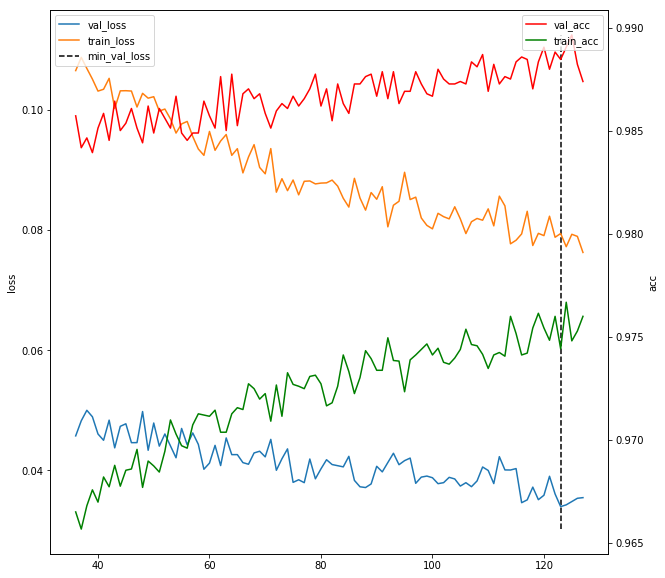

CPU times: user 21min 6s, sys: 54.7 s, total: 22min
Wall time: 18min 36s


In [13]:
%%time

# == HYPERPARAMETERS
dense_sizes = [256, 128]
dropouts = [0.25, 0.25]
learning_rate = 0.001
batch_size = 128
n_epoch = 128
patience = 32

# == CREATING MODEL
mlp_model = create_mlp_model(dense_sizes, dropouts)

# == OPTIMIZER, LOSS AND COMPILATION
adam_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.999)
my_loss = keras.losses.categorical_crossentropy
mlp_model.compile(adam_opt, my_loss, metrics=['accuracy'])

# == CALLBACKS
mlp_callbacks, ckpt_path = create_callbacks('mlp', patience=patience)

# == INPUT GENERATORS

# generators that loops forever
train_generator = img_gen_train.flow(x_train_k, y_train_k, batch_size = batch_size, seed=42, shuffle=True)
val_generator = img_gen_val.flow(x_val_k, y_val_k, batch_size = len(x_val_k), shuffle=False)

# == FIT

hist = mlp_model.fit_generator(train_generator, steps_per_epoch=None, epochs=n_epoch, verbose=2, 
                        callbacks= mlp_callbacks, validation_data = val_generator)

# == LOSS CURVE
plot_train_hist(hist)

### Predict

Let´s restore best model weights and make a prediction on test data



In [14]:
def predict_test(model, x_test, img_gen, n_augment = 1):
    # channels dim
    x_test_k = np.expand_dims(x_test, axis = 1)
    
    # use the trained image generator pipeline (it should not do data augmentation)
    test_generator = img_gen.flow(x_test_k, batch_size= len(x_test_k), shuffle=False)
    
    y_test = None
    i = 0
    for x_test_prep in test_generator:
        if y_test is None:
            y_test = model.predict(x_test_prep)
        else:
            y_test += model.predict(x_test_prep)

        i += 1
        if i >= n_augment:
            break
    
    y_test_label = y_test.argmax(axis = 1)
    y_test = y_test/y_test.sum(axis = 1, keepdims=True)
    
    return y_test, y_test_label

def validation_metrics(model, x_val, y_val, img_gen_val, n_augment = 1):
    
    y_pred, y_pred_label = predict_test(model, x_val, img_gen_val, n_augment)
    y_val_k = keras.utils.to_categorical(y_val, num_classes)
    
    loss = keras.metrics.categorical_crossentropy(y_val_k, y_pred)
    loss = keras.backend.eval(loss).mean()
    
    acc = keras.metrics.categorical_accuracy(y_val_k, y_pred)
    acc = keras.backend.eval(acc).mean()
    
    print('val loss:', loss, ' val acc:', acc)
    

In [15]:
# loading best weights
mlp_model.load_weights(ckpt_path)

# print validation metrics evaluation
validation_metrics(mlp_model, x_val, y_val, img_gen_val)

# test set prediction
y_test, y_test_label = predict_test(mlp_model, x_test, img_gen_train, n_augment=10)

y_test.shape, y_test_label.shape

val loss: 0.033935044  val acc: 0.9884524


((28000, 10), (28000,))

(<matplotlib.image.AxesImage at 0x7fa8b023f940>, 4)

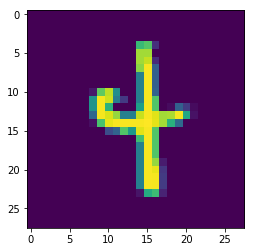

In [16]:
i = np.random.randint(0, len(x_test))
plt.imshow(x_test[i]), y_test_label[i]

### Creating Submission

In [17]:
def create_submission(y_test_label, model_name = 'model'):
    filepath = './' + model_name + '.csv'
    df = pd.DataFrame(data = {'ImageId' : range(1, len(y_test) + 1), 'Label' : y_test_label})    
    df.to_csv(filepath, index = False)
    print('Submission saved in', filepath)

In [18]:
create_submission(y_test_label, 'mlp')

Submission saved in ./mlp.csv


The first submission, with 

- dense_sizes = [100,100]
- dropouts = [0.5, 0.5]
- learning_rate = 0.001
- batch_size = 32
- validation metrics: [0.11049949377775192, 0.9695237874984741]

scored 0.9670 in LB.


The second submission, with

- **ImageDataGenerator(rescale=1/255., rotation_range = 12, width_shift_range=0.08, height_shift_range=0.08, zoom_range=0.08)**
- dense_sizes = [150,100]
- dropouts = [0.2, 0.2]
- learning_rate = 0.001
- batch_size = 64
- validation metrics: [0.049472346901893616, 0.9845238327980042]

scored 0.98657 in LB.


# CNN Model

In [19]:
def create_cnn_model(num_classes = 10, activation = 'relu'):
    
    inputs = keras.Input(shape=(1,28,28))
    x = inputs    
    
    # == inception-like block ==
    i_1 = keras.layers.Conv2D(32, 1, activation=activation)(x)
    i_1 = keras.layers.MaxPool2D()(i_1)
    
    i_3 = keras.layers.Conv2D(32, 3, padding='same', activation=activation)(x)
    i_3 = keras.layers.MaxPool2D()(i_3)
    
    i_5 = keras.layers.Conv2D(32, 5, padding='same', activation=activation)(x)
    i_5 = keras.layers.MaxPool2D()(i_5)
    
    i_avg = keras.layers.AveragePooling2D()(x)
    
    i_conc = keras.layers.concatenate([i_1, i_3, i_5, i_avg], axis = 1)
    x = i_conc
    # ==
    
    x = keras.layers.Conv2D(64, 5, strides = 1, padding='valid', activation=activation)(x)
    x = keras.layers.MaxPool2D()(x)
    
    x = keras.layers.Conv2D(256, 3, strides = 1, padding='valid', activation=activation)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dense(64, activation=activation, kernel_regularizer=keras.regularizers.l1(0.0001))(x)    
    x = keras.layers.Dropout(0.5)(x)
    
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    cnn_model = keras.Model(inputs = inputs, outputs = outputs)    
    cnn_model.summary()
    
    return cnn_model

In [20]:
def train_cnn(model_name = 'cnn', learning_rate = 1e-3, batch_size = 128, n_epoch = 32, patience= 16, activation = 'relu', 
              lr_reduction_params={'factor' : 0.5, 'patience' : 8, 'min_delta' : 0}, 
             train_generator = None, val_generator = None, train_ds = None, val_ds = None, steps_per_epoch = None):
    
    # == CREATING MODEL
    cnn_model = create_cnn_model(activation=activation)

    # == OPTIMIZER, LOSS AND COMPILATION
    # The ReduceLROnPlateau callback didn't work with tf.train.AdamOptimizer
    #adam_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.999)
    
    adam_opt = tf.keras.optimizers.Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999)

    my_loss = keras.losses.categorical_crossentropy
    cnn_model.compile(adam_opt, my_loss, metrics=['accuracy'])

    # == CALLBACKS
    cnn_callbacks, cnn_ckpt_path = create_callbacks(model_name, patience=patience, lr_reduction_params=lr_reduction_params)

    # == FIT
    if train_generator is not None:
        cnn_hist = cnn_model.fit_generator(train_generator, steps_per_epoch=None, epochs=n_epoch, verbose=2, 
                                           callbacks = cnn_callbacks, validation_data = val_generator)
    elif train_ds is not None:
        cnn_hist = cnn_model.fit(train_ds.make_one_shot_iterator(), steps_per_epoch=steps_per_epoch, epochs=n_epoch, 
                                 verbose=2, callbacks = cnn_callbacks, validation_data = val_ds.make_one_shot_iterator(), 
                                 validation_steps = 1)

    # == LOSS CURVE
    plot_train_hist(cnn_hist)
    
    return cnn_model, cnn_hist, cnn_ckpt_path

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 28, 28)   64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 28, 28)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 28, 28)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

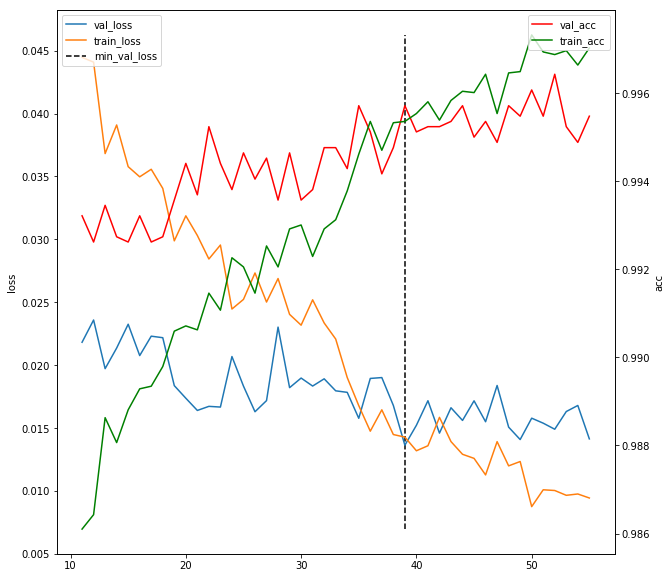

CPU times: user 12min 3s, sys: 42.9 s, total: 12min 45s
Wall time: 9min 38s


In [21]:
%%time

# == HYPERPARAMETERS
learning_rate = 0.001
batch_size = 128
n_epoch = 128
patience = 16

# generators that loops forever
train_generator = img_gen_train.flow(x_train_k, y_train_k, batch_size = batch_size, seed=42, shuffle=True)
val_generator = img_gen_val.flow(x_val_k, y_val_k, batch_size = len(x_val_k), shuffle=False)

cnn_model, cnn_hist, cnn_ckpt_path = train_cnn(model_name = 'cnn', learning_rate = learning_rate, batch_size = batch_size, n_epoch = n_epoch, 
                                               patience= patience, activation = 'relu', lr_reduction_params={'factor' : 0.5, 'patience' : 8, 'min_delta' : 0}, 
                                               train_generator = train_generator, val_generator = val_generator)


### Predict CNN

In [22]:
%%time

cnn_model.load_weights(cnn_ckpt_path)

validation_metrics(cnn_model, x_val, y_val, img_gen_val)

y_test, y_test_label = predict_test(cnn_model, x_test, img_gen_val)

create_submission(y_test_label, 'cnn')

y_test_aug, y_test_label_aug = predict_test(cnn_model, x_test, img_gen_train, n_augment=10)

create_submission(y_test_label_aug, 'cnn_aug')

val loss: 0.013639366  val acc: 0.9957143
Submission saved in ./cnn.csv
Submission saved in ./cnn_aug.csv
CPU times: user 1min 30s, sys: 3.7 s, total: 1min 33s
Wall time: 1min 27s


Submission 1:

- conv5 -> maxpool /2 -> conv5 -> maxpool /2 -> dense -> dense10
- learning_rate = 0.001
- batch_size = 128
- n_epoch = 128
- patience = 32
- validation metrics: [0.019111450761556625, 0.9936904907226562]

scored 0.9920 in LB.

Submission 2:

- inception_block -> conv5 -> maxpool -> conv3 -> maxpool -> dense10
- learning_rate = 0.0005
- batch_size = 128
- n_epoch = 128
- patience = 32
- validation metrics: [0.011771622113883495, 0.9957143068313599]

scored 0.9950 in LB.

and Submission 3:
- inception_block (/2) -> conv5 -> maxpool -> conv3 -> avgpool -> dropout -> dense10
- learning_rate = 0.001 + ReduceLRonPlateau(factor = 0.5, patience = 8) 
- patience = 16

scored 0.9950 in LB.

Submission 3 + test_data_augmentation (n_augment = 10)

**scored 0.99585 in LB.**


# Data Input Pipeline with tf.data


In [23]:
def plot_batch(imgs):
    n_row, n_col = (int(np.ceil(len(imgs)/8)), 8) if len(imgs) > 8 else (1, len(imgs))
    
    fig, axs = plt.subplots(n_row, n_col, figsize = (2.5*n_col,2.5*n_row))

    for i in range(len(imgs)):
        z = imgs[i]
        if len(z.shape) == 3:
            z = z[0]
        if i+1 > n_row*n_col:
            break
        row, col = (i)//n_col, (i)%n_col
        if len(axs.shape) == 2:
            axs[row,col].imshow(z, cmap='gray', interpolation='none')
        else:
            axs[col].imshow(z, cmap='gray', interpolation='none')

    plt.show()

In [24]:
def _preprocess_img(img, label, angle_range = 12, translation_range = 0.08, 
                    zoom_range = 0.08, method = 'bilinear', augmentation_fraction = 0.8):
    img = img / 255.
    img_no_aug = tf.reshape(img, (1, 28, 28))
    
    # tf.image transformations need: NHWC    
    img = tf.reshape(img, (1, 28, 28, 1))
    
    # == random rotation
    if angle_range is not None:
        angle_range_rad = np.deg2rad(angle_range)
        random_angle = tf.random.uniform((1,), -angle_range_rad, angle_range_rad)
        img = tf.contrib.image.rotate(img, angles = random_angle, interpolation=method.upper())
        
    
    # == crop and resize (= translate and zoom)
    min_corner = tf.constant([0,0], dtype=tf.float32, shape=[2])
    
    if translation_range is not None:
        min_corner = min_corner + tf.random_uniform(shape = (2,) , minval=-translation_range, maxval=translation_range)
    max_corner = min_corner + [1,1]
    
    if zoom_range is not None:
        random_zoom = tf.random.uniform((1,), minval=1-zoom_range, maxval=1+zoom_range)
        center = (min_corner + max_corner)/2.
        min_corner_new = center + random_zoom * (min_corner - max_corner)/2.
        max_corner_new = center + random_zoom * (max_corner - min_corner)/2.
        min_corner = min_corner_new
        max_corner = max_corner_new
    
    box = tf.concat([min_corner, max_corner], axis = 0)
    boxes = tf.reshape(box, (1, 4))    
    
    img = tf.image.crop_and_resize(img, boxes, [0], crop_size = (28,28), method=method, extrapolation_value=0, name=None)
    img = tf.cast(img, tf.float64)
    
    # changing to CHW
    img = tf.reshape(img, (1, 28, 28))
    
    # final image -> randomly choose to do (or not) augmentation
    do_aug = tf.random.uniform([], minval=0, maxval=1)
    img = tf.cond(do_aug <= augmentation_fraction, lambda: img, lambda: img_no_aug)
    
    # label
    y = tf.one_hot(label, 10)
    return img , y

def build_input_dataset(x, y, batch_size = 32, mode = 'train', preprocess_img_params = dict()):
    ds = tf.data.Dataset.from_tensor_slices((x, y))    
    map_func = lambda img,label : _preprocess_img(img, label, **preprocess_img_params)
    
    if mode == 'train':
        # ideally shuffle´s buffer_size should be n_samples but in this case data has already been shuffled
        ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=1024))
        ds = ds.apply(tf.data.experimental.map_and_batch(map_func, batch_size, num_parallel_batches=None, drop_remainder=False, num_parallel_calls=None))
    else:
        ds = ds.apply(tf.data.experimental.map_and_batch(map_func, len(x), num_parallel_batches=None, drop_remainder=False, num_parallel_calls=None))
        df = ds.cache()
        ds = ds.repeat()
        
    ds = ds.prefetch(1)
    return ds

original


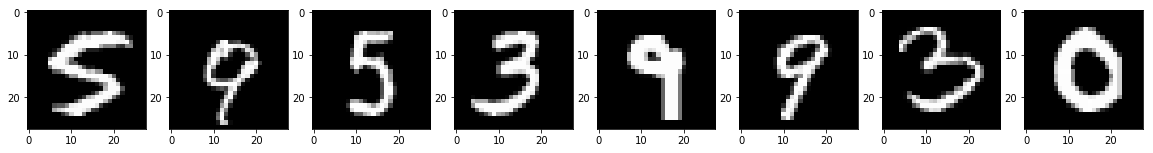

==================== batch 1 ====================
imgs.shape: (3, 1, 28, 28) labels.shape: (3, 10)


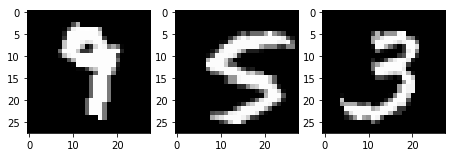

==================== batch 2 ====================
imgs.shape: (3, 1, 28, 28) labels.shape: (3, 10)


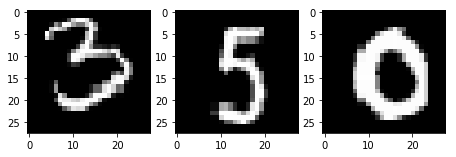

==================== batch 3 ====================
imgs.shape: (3, 1, 28, 28) labels.shape: (3, 10)


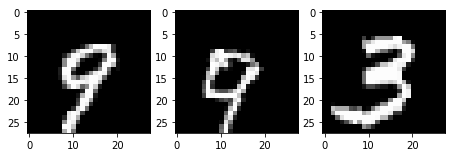

==================== batch 4 ====================
imgs.shape: (3, 1, 28, 28) labels.shape: (3, 10)


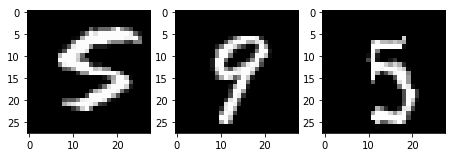

CPU times: user 7.51 s, sys: 1.64 s, total: 9.15 s
Wall time: 8.64 s


In [25]:
%%time

idx_examples = np.random.randint(0, len(x_train), size=8)
print('original')
x_examples = x_train[idx_examples]
y_examples = y[idx_examples]
plot_batch(x_examples)

ds = build_input_dataset(x_examples, y_examples, batch_size=3, mode='train', preprocess_img_params={'method' : 'nearest', 'angle_range' : 12})
it = ds.make_one_shot_iterator()
elem = it.get_next()

with tf.Session() as sess:
    for j in range(4):
        print('='*20, 'batch',j+1, '='*20)
        imgs, labels = sess.run(elem)
        print('imgs.shape:', imgs.shape, 'labels.shape:', labels.shape)
        plot_batch(imgs)

    


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 28, 28)   64          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 28, 28)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 28, 28)   832         input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

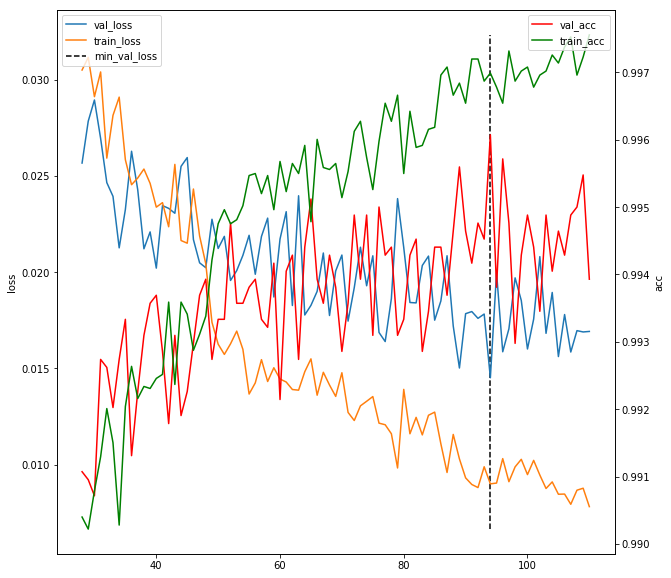

CPU times: user 22min 31s, sys: 1min 47s, total: 24min 18s
Wall time: 13min 23s


In [26]:
%%time

# == HYPERPARAMETERS
learning_rate = 0.001
batch_size = 128
n_epoch = 128
patience = 16
method = 'nearest'
augmentation_fraction = 0.8

# generators that loops forever
train_ds = build_input_dataset(x_train, y_train, batch_size=batch_size, mode='train', 
                               preprocess_img_params={'method' : method, 'augmentation_fraction' : 0.8})

steps_per_epoch = len(x_train) // batch_size

val_ds = build_input_dataset(x_val, y_val, mode='val')

cnn2_model, _, cnn2_ckpt_path = train_cnn(model_name = 'cnn2_{}'.format(method), learning_rate = learning_rate, n_epoch = n_epoch, steps_per_epoch=steps_per_epoch,
                                               patience = patience, activation = 'relu', lr_reduction_params={'factor' : 0.5, 'patience' : 8, 'min_delta' : 0}, 
                                               train_ds = train_ds, val_ds = val_ds)
